# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [222]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [223]:
# 🔓
l = 50 / 100
r = 12.5 / 100

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the scooter (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [224]:
# 🔓
def draw_scooter(x, y, theta):
    translation = array([[x], [y]])
    rotation = array([
        [cos(theta), -sin(theta)], 
        [sin(theta),  cos(theta)]
    ])

    # Left pad
    corners = [[0, 0], [-r, l/2], [r, l/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="red", zorder=10)

    # Right pad
    corners = [[0, 0], [r, -l/2], [-r, -l/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="red", zorder=10)
    
    # Fixed Wheels
    wheel_left_xy_start = rotation @ [[-r], [-l/2]] + translation 
    wheel_left_xy_end = rotation @ [[r], [-l/2]] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5, zorder=20)

    wheel_right_xy_start = rotation @ [[-r], [l/2]] + translation
    wheel_right_xy_end = rotation @ [[r], [l/2]] + translation
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5, zorder=20)

    # Forward marker
    xm, ym = rotation @ array([0.5, 0]) + array([x, y])
    plot([xm], [ym], "o", color="green")


🧩 Represent the scooter when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [225]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

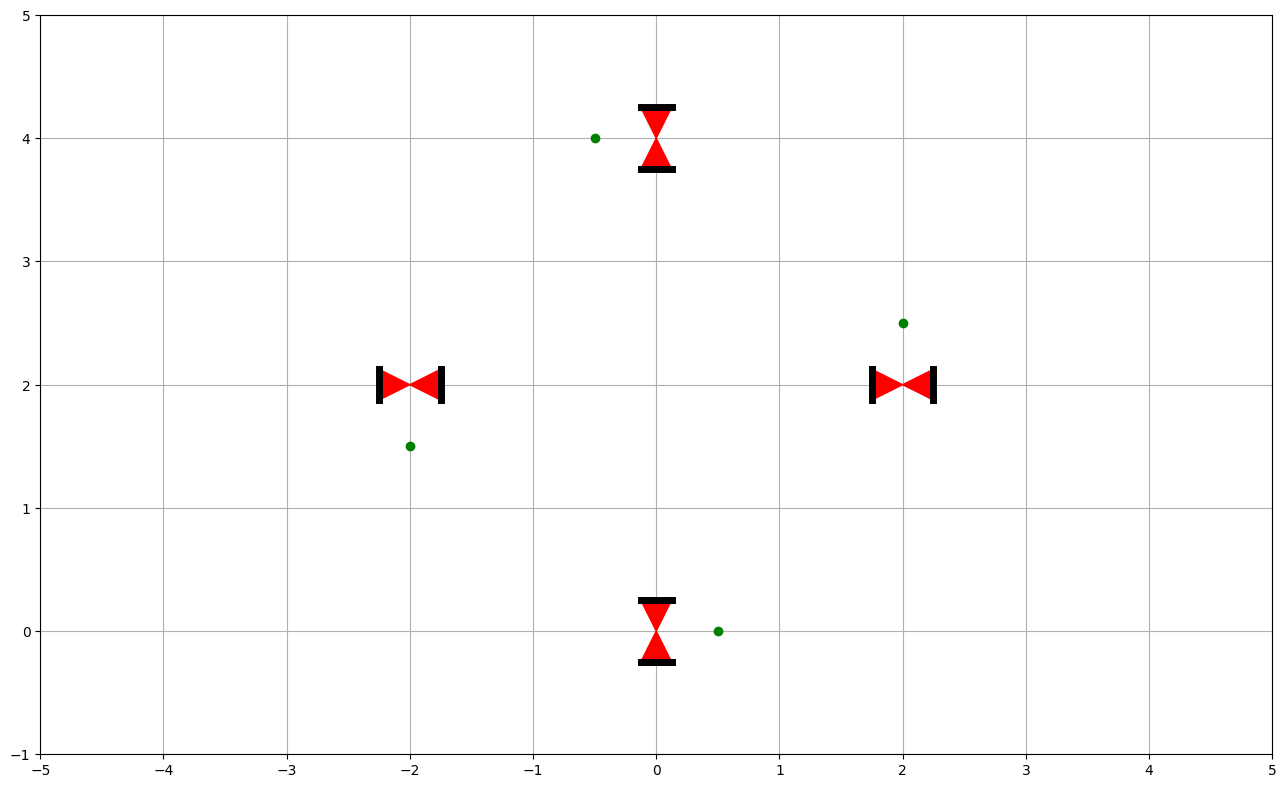

In [226]:
# 🔓
draw_arena(-5, 5, -1, 5)
draw_scooter(0, 0, 0)
draw_scooter(2, 2, pi/2)
draw_scooter(0, 4, pi)
draw_scooter(-2, 2, 3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the scooter).
We also assume that the scooter fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

🔓
$$
\begin{array}{rcl}
\dot{x} &=& r  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& r  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& r  \frac{\omega_r - \omega_l}{\ell} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

🔓 The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

🔓 When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 (\ell/r)  \theta^2$, we end up with $\dot{\theta}(t) = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [227]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [228]:
# 🔓
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = r * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = r * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = r * (omega_r - omega_l) / l
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the scooter dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [229]:
# 🔓
results = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

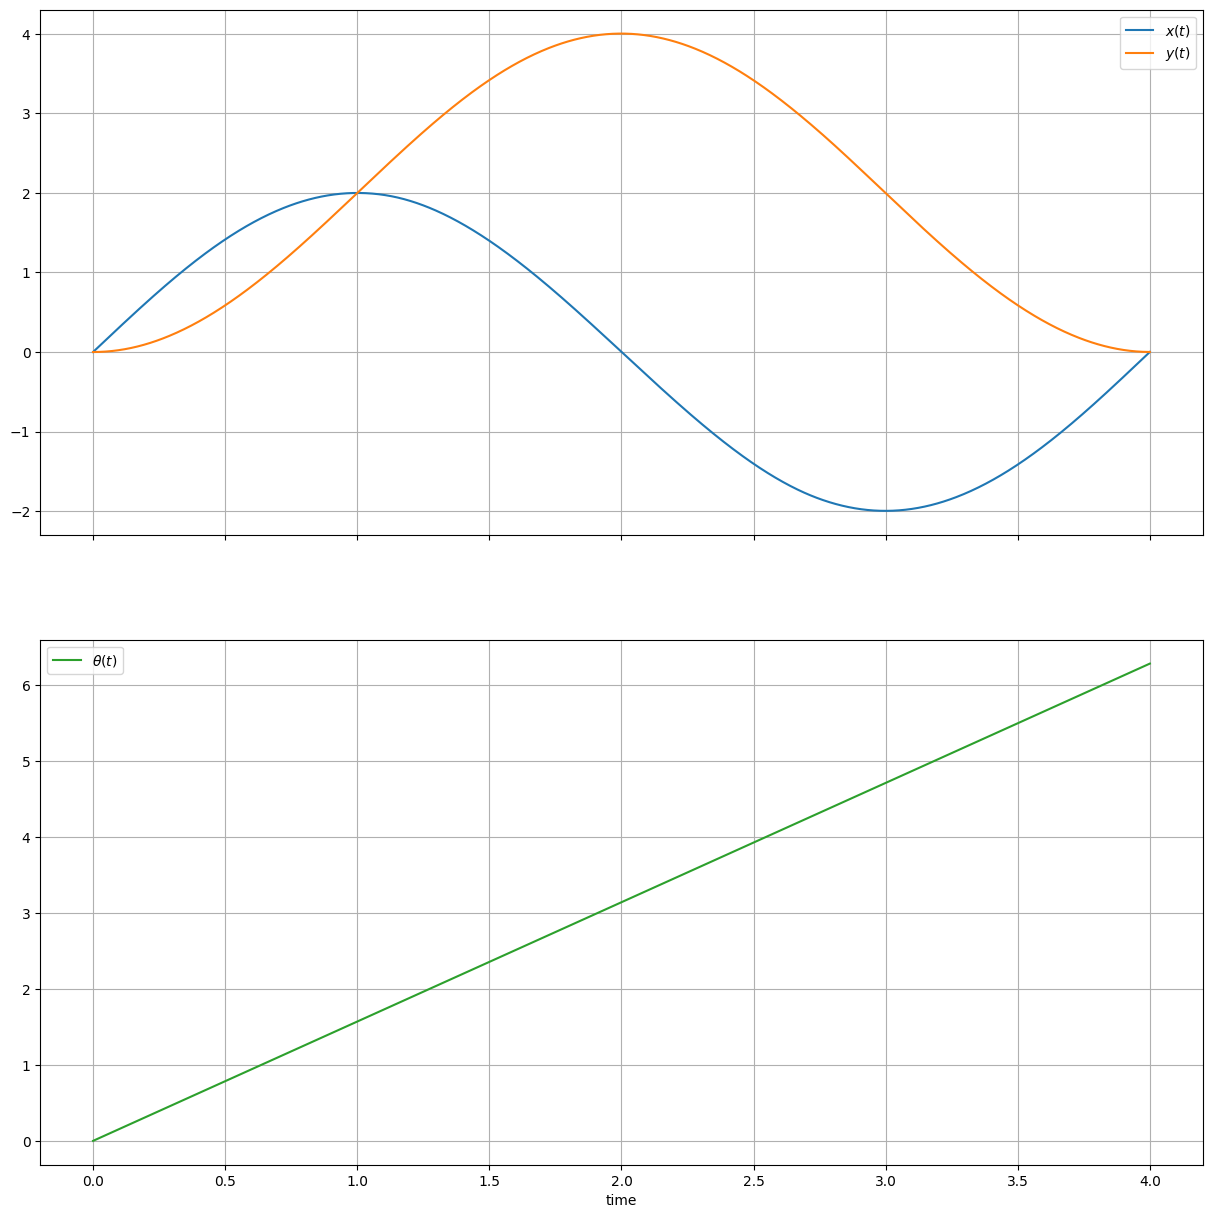

In [230]:
# 🔓
t = linspace(0.0, 4.0, 1000)
x, y, theta = results["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
xlabel("time")
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

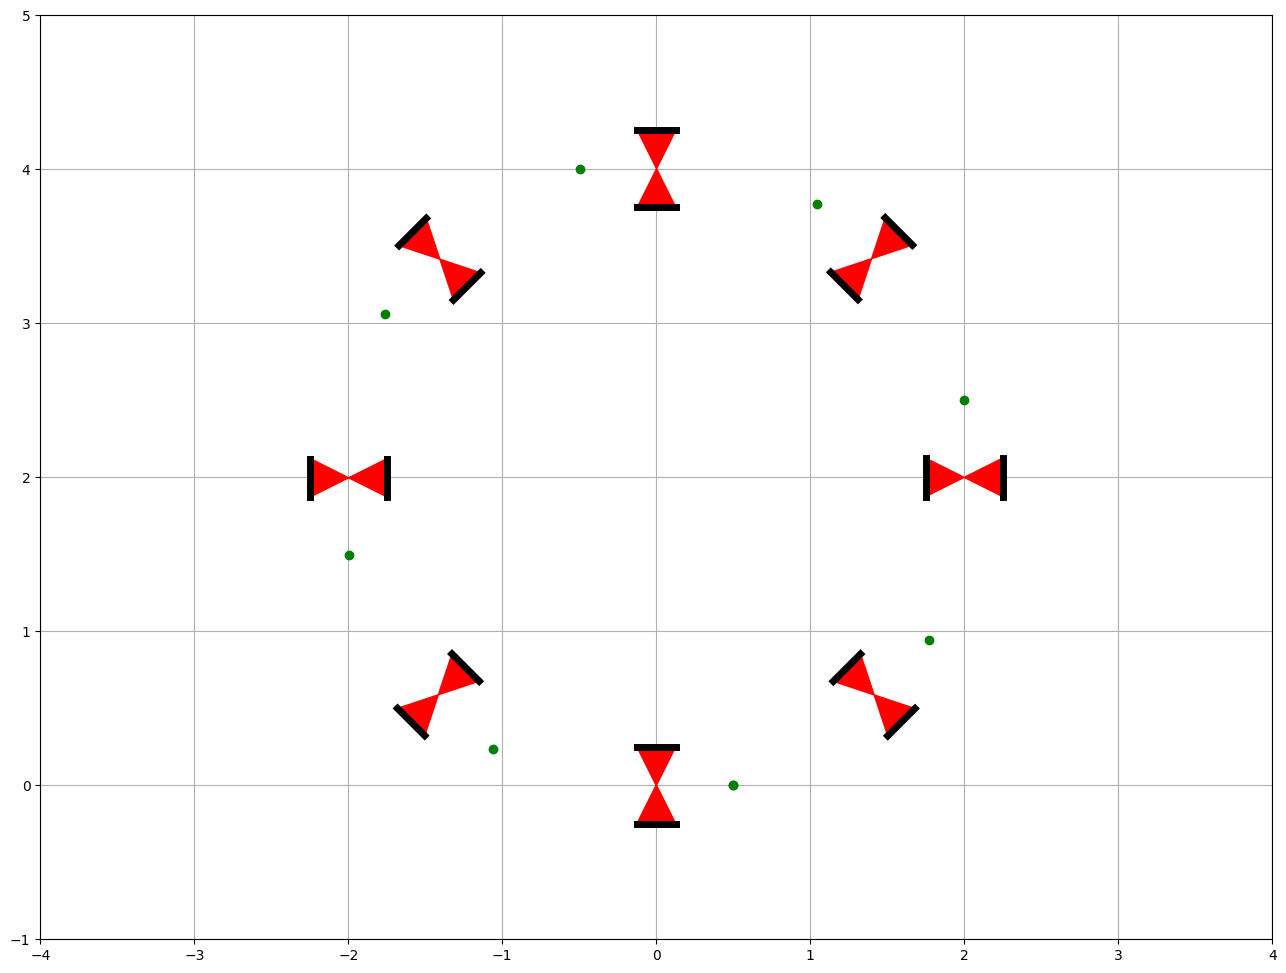

In [231]:
# 🔓
t = linspace(0.0, 4.0, 4*2+1)
sol_t = results["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_scooter(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

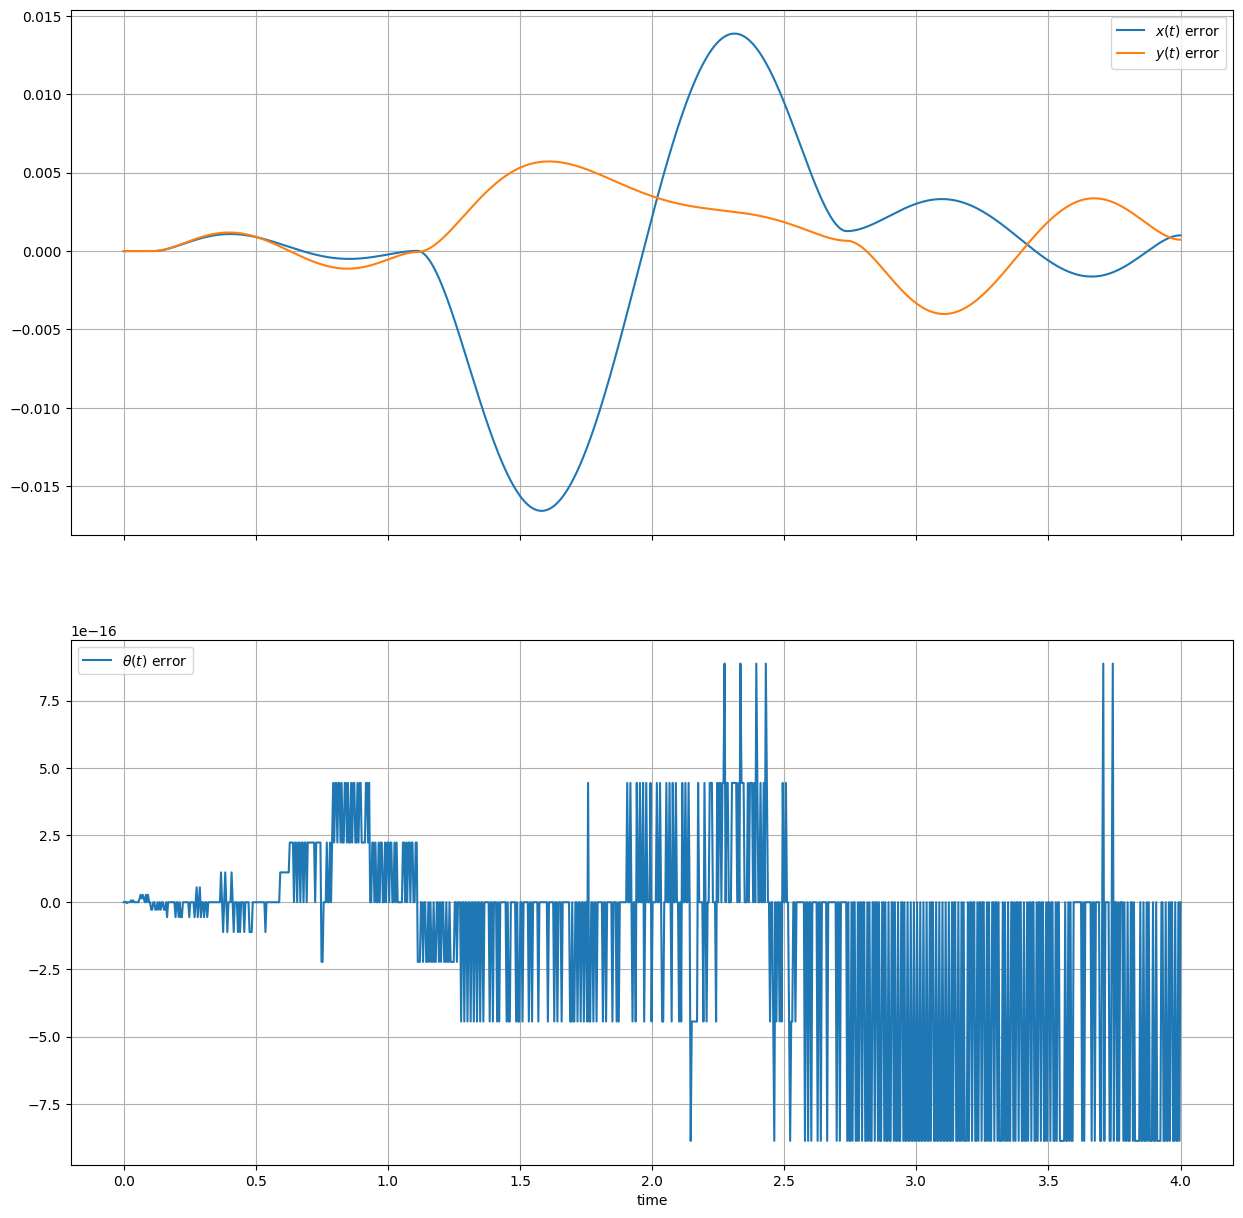

In [232]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = results["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

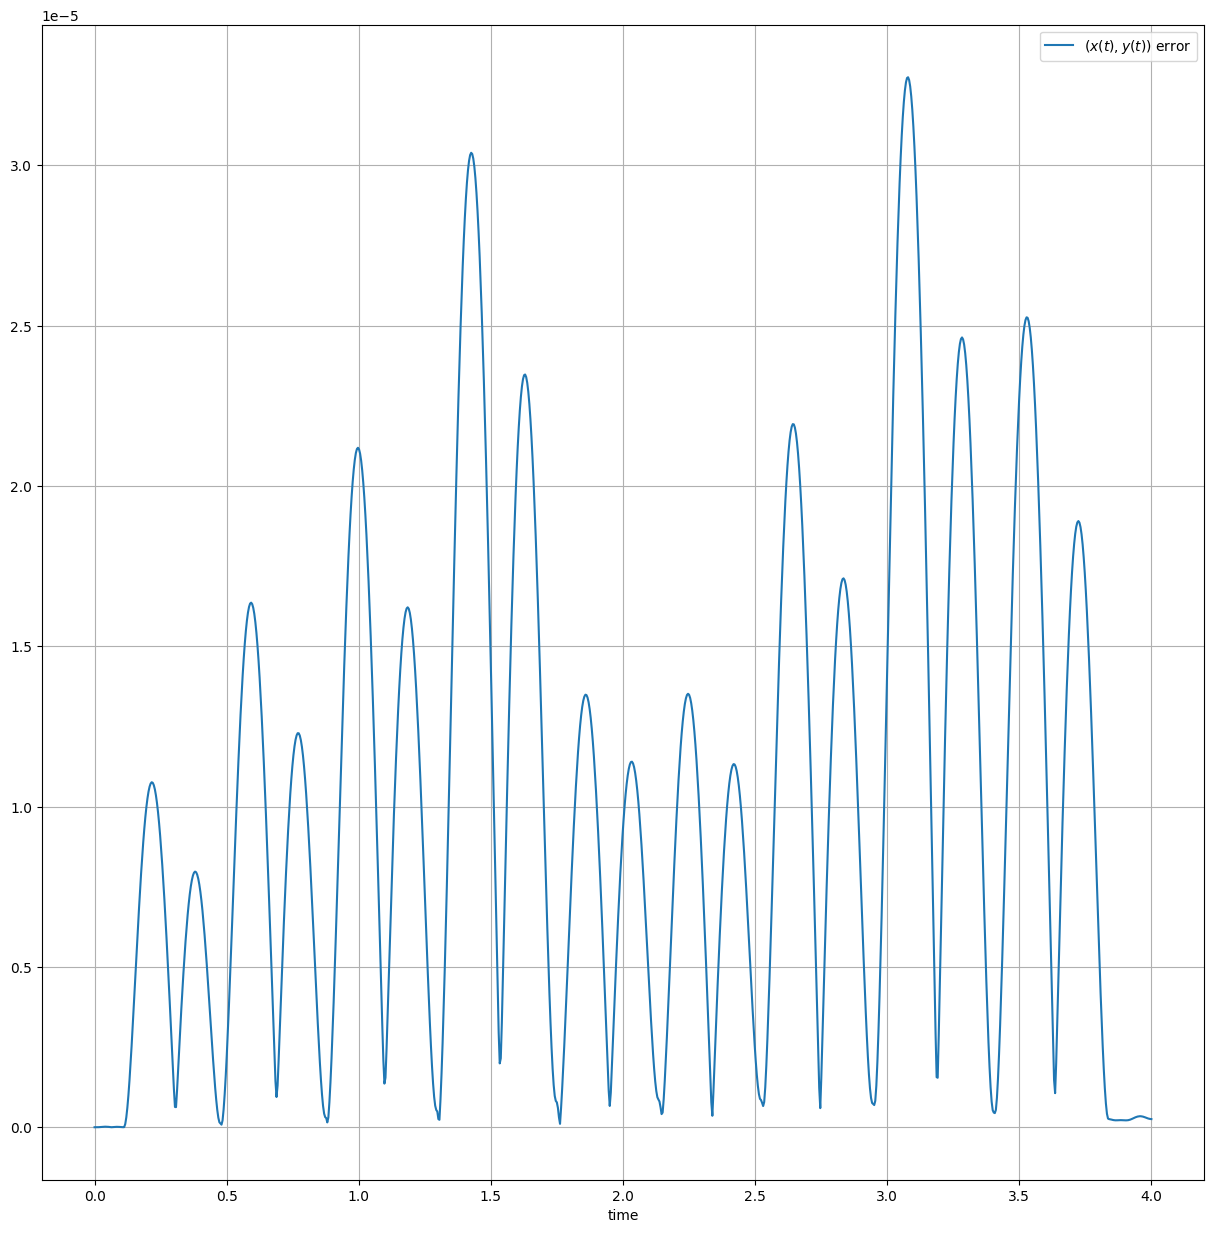

In [233]:
results = solve_ivp(
    fun=fun, 
    t_span=(0.0, 4.0), 
    y0=[0.0, 0.0, 0.0], 
    rtol=1e-6, 
    atol=1e-6, 
    dense_output=True
)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = results["sol"](t)
figure(figsize=(15, 15))
grid(True)
plot(t , sqrt((x_t - 2*sin(2*pi*t/4))**2 + (y_t + 2*cos(2*pi*t/4) - 2)**2) , label="$(x(t), y(t))$ error")
legend()
grid(True)
xlabel("time")
pass

Step 2 - Control Implementation
===============================

Time dependent inputs
---------------------

We are going to simulate the case of the scooter controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$. 
We want a simulation lasting 5 seconds with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{rl}
           (1 - \ell/4) \pi / r & \mbox{when $t \leq 1 \,  \mathrm{s}$ or  $t \geq 3 \,  \mathrm{s}$,} \\
           (1 + \ell/4) \pi / r & \mbox{otherwise.}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{rl}
           (1 + \ell/4) \pi / r & \mbox{when $t \leq 1 \,  \mathrm{s}$ or $t \geq 3 \,  \mathrm{s}$,} \\
           (1 - \ell/4) \pi / r & \mbox{otherwise.}
       \end{array}
    \right.
$$

##### 🧩 Provide the new definition of `omega`

In [234]:
def omega(t, xytheta):
  if t <= 1 or t >= 3:
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
  else:
    omega_l = (1 + l/4) * pi / r
    omega_r = (1 - l/4) * pi / r

  return array([omega_l, omega_r])

##### 🧩 Make a simulation of 4 sec of the robot with the previous input. Use the `rtol` and `atol` that used to guarantee a precision of $1 \, \mathrm{mm}$ and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** It is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`.  

In [235]:
results = solve_ivp(
    fun=fun, 
    t_span=(0.0, 4.0), 
    y0=[0.0, 0.0, 0.0], 
    rtol=1e-6,
    atol=1e-6, 
    dense_output=True
)

Text(0.5, 0, 'time')

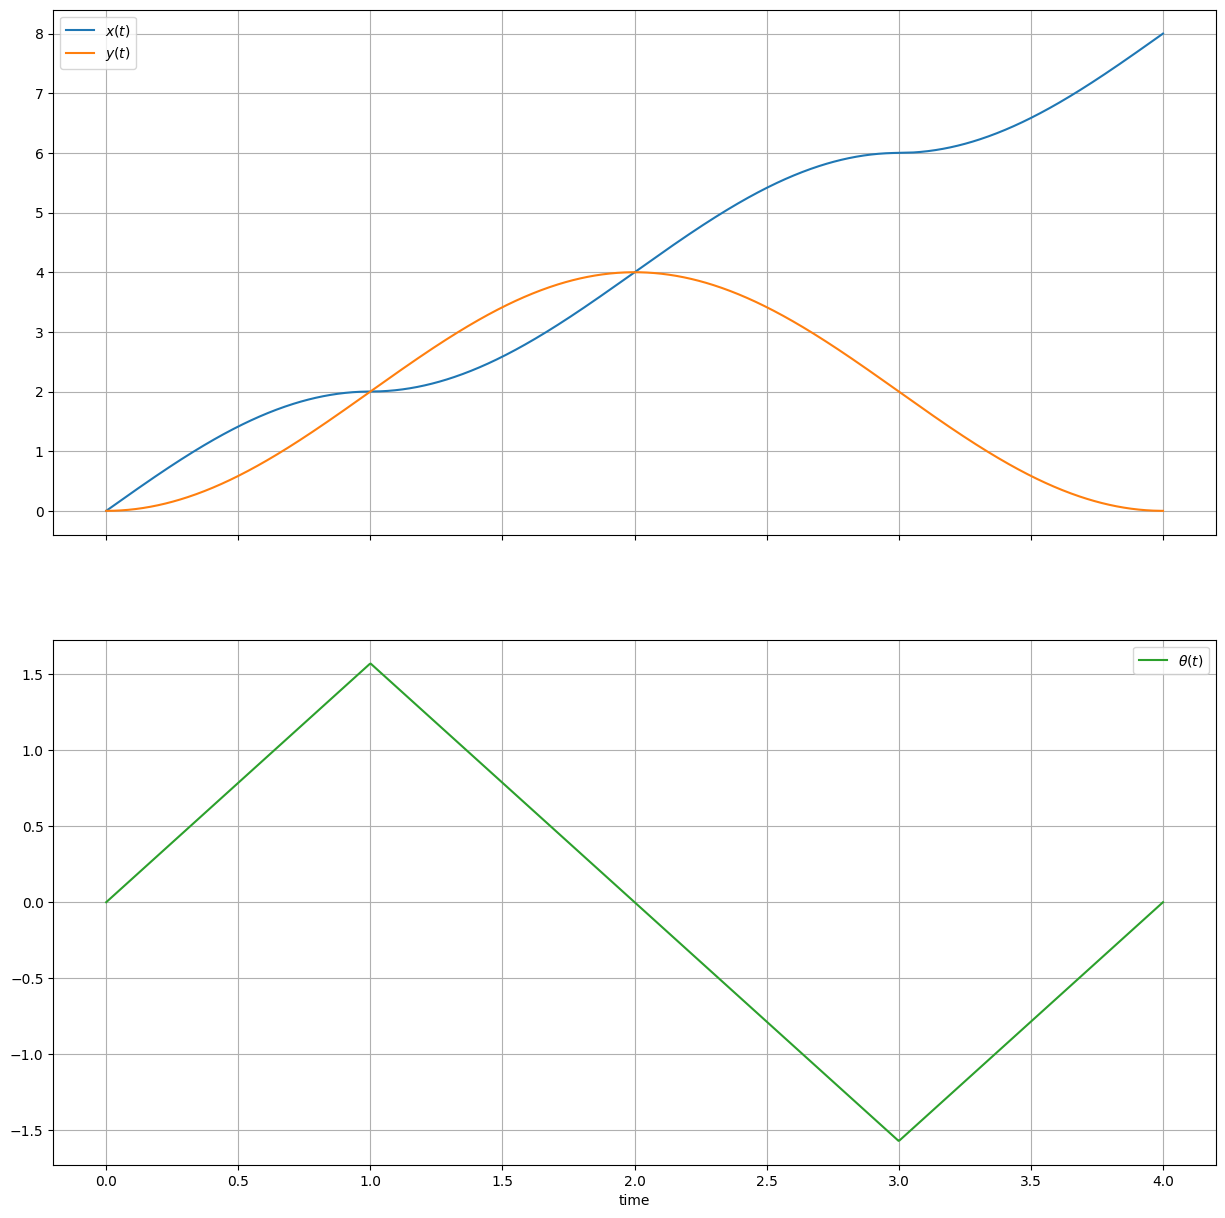

In [236]:
t = linspace(0.0, 4.0, 1000)
x, y, theta = results["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
xlabel("time")

🧩 Use the simulation results to display the robot location every 0.5 seconds.

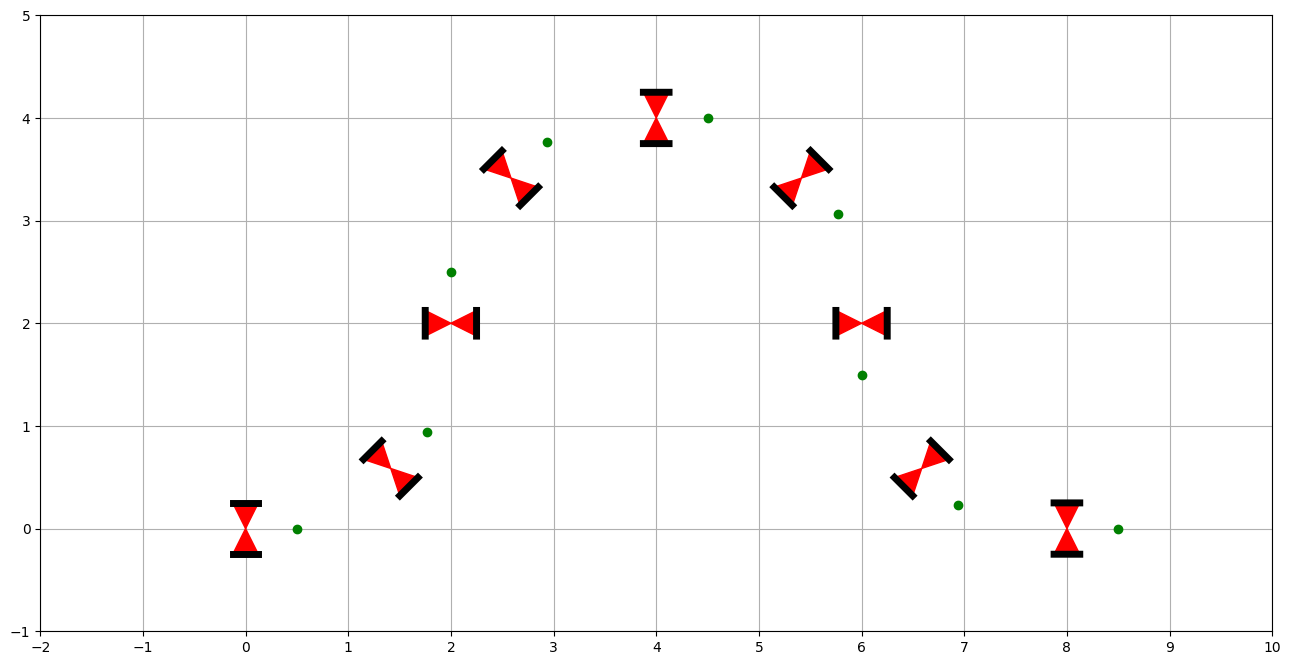

In [237]:
t = linspace(0.0, 4.0, 4*2+1)
sol_t = results["sol"](t)
draw_arena(-2, 10, -1, 5)
for x, y, theta in sol_t.T:
    draw_scooter(x, y, theta)

## Analysis of the system at rest

### Equilibrium

##### 🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the scooter kinematic model.

We can take for example $\omega_e$ = (0,0), this way the linear velocity V = 0 and the scooter does not move so it is at equilibrium

##### 🧩 Show that for any other $\omega_e$, the system has no equilibrium.

When either $\omega_l$ or $\omega_r$ is non-zero, there are two possible scenarios:

1. If $\omega_l \neq -\omega_r$ and both are not equal to zero, then $\dot{x} = \dot{y} = 0$ would necessitate that $\cos\theta = \sin\theta = 0$, which is impossible since trigonometric functions cannot simultaneously equal zero.

2. If $\omega_l = -\omega_r$ and both are different from zero, then $\dot{\theta} = 2\omega_r \frac{R}{D} \neq 0$. In this case, the scooter will rotate on itself.

In both cases, the system cannot be in equilibrium.

##### 🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

Given the scooter kinematic model equations:

$$
\begin{array}{rcl}
\dot{x} &=& r  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& r  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& r  \frac{\omega_r - \omega_l}{\ell} \\
\end{array}
$$

Let's consider the case where \( $\omega_e$ = ($\omega_l$, $\omega_r$) = (0,0) \):

Substituting \( $\omega_l$ = 0 \) and \( $\omega_r$ = 0 \) into the equations:

$$
\begin{array}{rcl}
\dot{x} &=& r  \frac{0 + 0}{2} \cos \theta = 0 \\
\dot{y} &=& r  \frac{0 + 0}{2} \sin \theta = 0 \\
\dot{\theta} &=& r  \frac{0 - 0}{\ell} = 0
\end{array}
$$


Since $\dot{x} = 0, \dot{y} = 0$, and $\dot{\theta} = 0$ , all derivatives of the state variables are zero, indicating that there is no change in position or orientation over time. Therefore, if  $\omega_e = (\omega_l, \omega_r) = (0,0)$ , then every point $(x, y, \theta)$ is indeed a point of equilibrium, as the system remains stationary and does not exhibit any motion or rotation.

### Linearized System Model


Let $\omega = \omega_e$ and $X_e = (0,0,0)$. Let us introduce the the error variable $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$ and $\Delta \omega = \omega - \omega_e$.

##### 🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$).

Let's consider $\omega = \omega_e$ and $X_e = (0,0,0)$. We have $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e = X$ and $\Delta \omega = \omega - \omega_e = \Delta \omega$.

$\Delta X =\begin{bmatrix}
 x\\ y\\ \theta
\end{bmatrix} $


$\frac{d}{dt}. \begin{bmatrix} x\\ y\\ \theta \end{bmatrix}$
$ = \begin{bmatrix} 
r  \frac{\omega_l + \omega_r}{2} \cos \theta \\
r  \frac{\omega_l + \omega_r}{2} \sin \theta\\
r  \frac{\omega_r - \omega_l}{\ell}
\end{bmatrix}$
$ = \begin{bmatrix} 
0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 
\end{bmatrix}$ .
$ \begin{bmatrix} 
x \\ y \\ \theta
\end{bmatrix}$
$ + \begin{bmatrix} 
\frac{r}{2} \cos \theta & \frac{r}{2} \cos \theta \\
\frac{r}{2} \sin \theta & \frac{r}{2} \sin \theta \\
\frac{-r}{\ell} & \frac{r}{\ell}
\end{bmatrix}$
$ . \begin{bmatrix} 
\omega_l \\ \omega_r
\end{bmatrix}$
$\newline$

with $X_e = (0,0,0)$


$
A= \begin{bmatrix} 0 & 0 &0 \\ 0 & 0 &0 \\ 0 & 0 & 0\end{bmatrix}$
And
$B= \begin{bmatrix} 
\frac{r}{2}  & \frac{r}{2}\\
0 & 0\\
\frac{-r}{\ell} & \frac{r}{\ell}
\end{bmatrix}
$

### Stability of the linearized system

##### 🧩 Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

$A$ is a zero matrix, hence it has a null spectrum. Consequently, the only eigenvalue of $A$ is 0, which does not have a strictly negative real part. Therefore, the linearized system is not asymptotically stable around (0, 0, 0)

##### 🧩 Is the original system asymptotically stable ? Or even (locally) attractive ? 

**Réponse.**

Avec $\omega = \omega_e$, le système ne bouge pas. Si $X(t_0) = X_0$, alors $\forall t>0, X(t) =X_0$. Ainsi, si $X_0\neq (0,0,0)$, $X(t)$ ne converge pas vers l'origine : le système original n'est pas (même localement) attractif.

Par conséquent, il n'est pas asymptotiquement stable.

### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:

$$
\frac{\Delta X}{dt} = A \Delta X + B\Delta u
$$

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

**Réponse.** 

Oui, avec $\omega = (1,1)$, le robot se déplacera en ligne droite sur l'axe $(Ox)$ et atteindra l'origine après un certain temps en fonction de la vitesse.

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

On a $X_0=(0,2,0)$ 

Alors:  $\dot{y} = 0$ implique $\dot{y}{(t)} = {y_0} = 2$

Ce qui signifie que le système ne retournera pas à l'origine et par conséquent, il n'y aura de trajectoire admissible. 



##### 🧩 Is the linearized system controllable?

**Réponse.**

On a $A = 0$ donc la matrice de controlabilité ne sera autre que $B$. De plus $rang {[B]} = 2$ qui est différent du nombre d'état du système égal à 3. 
Par conséquent, le système linéaire n'est pas controllable. 

## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. 

##### 🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

Given the scooter kinematic model equations:

$$
\begin{array}{rcl}
\dot{x} &=& r  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& r  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& r  \frac{\omega_r - \omega_l}{\ell} \\
\end{array}
$$

$\dot{y} = 0 \implies \omega_l = -\omega_r$ or $\sin \theta = 0$

The 1st case is impossible because if it is true then:
$\omega_l = -\omega_r \implies \dot{x} = 0 = v$ (impossible because v is not null)

Let's work with the second case: $\sin \theta = 0 \implies \cos \theta = 1$ or $-1$

Given that: $\dot{\theta} = r  \frac{\omega_r - \omega_l}{\ell}$
and $\theta$ is constant then $\dot{\theta} = 0$ meaning $\omega_r = \omega_l$

Finally, we get: 
$\dot{x} =  \frac{\omega_l + \omega_r}{2} \cos \theta = \pm \frac{2 r \omega_l}{2} = \pm r \omega_l$

Let's integrate:
$\dot{x} = r \omega_l + C \implies v = r \omega_l$ and $C = 0$

Finally:

$X_R(t) = (x_R(t), y_R(t), \theta_R(t)) = (r \omega_l t, 0, k\pi) = (vt, 0, k\pi)$ with $k \in Z$
$\newline$
and
$\omega(t)=(v/r,v/r)$ if $\theta_R = 2k \pi$
$\newline$
 $\omega(t)=(-v/r,-v/r)$ if $\theta_R = \pi + 2k \pi$

### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

##### 🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".


$$
  A = \begin{bmatrix}
      0 & 0 & 0 \\
      0 & 0 & v \\
      0 & 0 & 0
  \end{bmatrix}
$$

and

$$
   B=\begin{bmatrix}
    \frac r2 & \frac r2  \\ 0 & 0 \\ -\frac rl & \frac rl
  \end{bmatrix}
$$

##### 🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

Same as the previous example, $A$ is a zero matrix, hence it has a null spectrum. Consequently, the only eigenvalue of $A$ is 0, which does not have a strictly negative real part. Therefore, the linearized system is not asymptotically stable around (0, 0, 0)

##### 🧩 Is the system attractive, with $\Delta\omega(t)=0$?

 because $\Delta\omega(t)=0$, $\Delta X$ doesn't change over time. Therefore the system isn't stable and, as a result, isn't attractive

##### 🧩 Show that the linearized system is controllable.

The system is controllable if the rank of the matrix $C$ is equal to $3$ (full rank)
$\newline C = [B, AB, A^2B]$

$B=\begin{bmatrix}
\frac{r}{2} & \frac{r}{2}  
\\ 0 & 0 
\\ -\frac{r}{l} & \frac{r}{l}
\end{bmatrix}$

$AB=\begin{bmatrix}
0 & 0  
\\ -v\frac{r}{l} & v\frac{r}{l} 
\\ 0 & 0 
\end{bmatrix}$
 
$ A^2B=\begin{bmatrix}
0 & 0  
\\ 0 & 0 
\\ 0 & 0 
\end{bmatrix}$
 
$\newline rank(C) = \begin{pmatrix}
\frac{r}{2} & \frac{r}{2} & 0 & 0 & 0 & 0 \\
0 & 0 & -\frac{vr}{l} & \frac{vr}{l} & 0 &  0 \\
-r & r & 0 & 0 & 0 & 0 \end{pmatrix} = 3$

The first three rows are linearly independent:

The system is indeed controllable

### Linearized system implementation

In the sequel, we will use $v=25 { km/h}$.

##### 🧩 Implement and print the matrices $A$ and $B$

In [238]:
import numpy as np
r = 0.125
l = 0.5
v = 25/3.6
A = np.array([[0, 0, 0], [0, 0, v], [0, 0, 0]])
B = np.array([[r/2, r/2], [0, 0], [-r/l, r/l]])
print(A)
print(B)

[[0.         0.         0.        ]
 [0.         0.         6.94444444]
 [0.         0.         0.        ]]
[[ 0.0625  0.0625]
 [ 0.      0.    ]
 [-0.25    0.25  ]]


The linear model has to be fed with some $\Delta\omega$ input. Like for the nonlinear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we set:

In [239]:
def deltaOmega(t, deltaX):
    return array([0, 0, 0])

##### 🧩 Using this function `deltaOmega`, define a function `lin_fun` that computes $d{\Delta X}/dt$ given the arguments `t` and `deltaX`$.

In [240]:
def lin_fun(t,deltaX):
  return A@deltaX + B@deltaOmega(t,deltaX)

### Controller Design on the linearized system

##### 🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. 

For this question, we will chose 3 real poles close to -1.0.

Then, print the poles of the closed-loop system

$$
\frac{d\Delta X}{dt}= A \Delta X + B\Delta\omega
\; $\{ with }$\;
\Delta\omega = -K \Delta X.
$$

In [241]:
poles=[-1.1,-1.2,-1.3]
K = place_poles(A, B, poles).gain_matrix
print(K)

closed_loop_poles = np.linalg.eigvals(A - np.dot(B, K))
print(closed_loop_poles)

[[ 9.59999736 -0.4033942  -4.75306943]
 [ 9.60000209  0.42028583  4.84693071]]
[-1.2 -1.3 -1.1]


In [242]:
import numpy as np
l = 0.5
r = 0.125
# Given matrices A and B
v = 25 / 3.6
A = np.array([[0, 0, 0], [0, 0, v], [0, 0, 0]])
B = np.array([[r/2, r/2],
              [0, 0],
              [r/l, -r/l]])

poles = [-1.1, -1.2, -1.3]  # Strictly negative real part
K = place_poles(A,B,poles).gain_matrix
print(K)
e,_ = np.linalg.eig(A - B @ K)

[[ 9.59999736  0.4033942   4.75306943]
 [ 9.60000209 -0.42028583 -4.84693071]]


##### 🧩 Simulate the linearized system during 20s, with the initial condition $\Delta X(0) = (0,2,0)$.

In [243]:
def deltaOmega(t, deltaX):
    return -K @ deltaX

results = solve_ivp(fun=lin_fun, 
                    t_span=[0, 20], 
                    y0=[0,2,0],
                    dense_output=True,
                    rtol=1e-8, atol=1e-8)

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

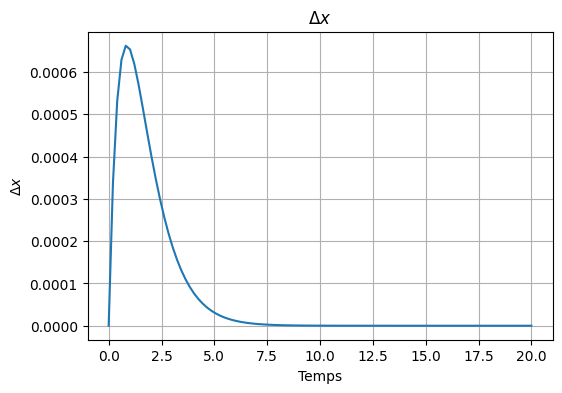

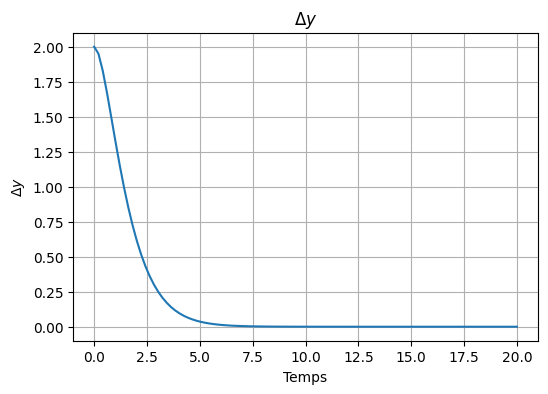

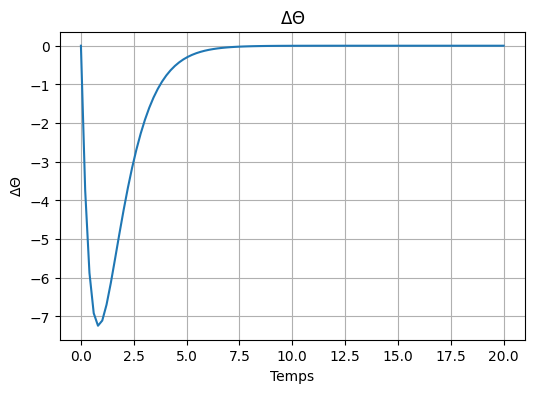

In [244]:
import numpy as np
import matplotlib.pyplot as plt


t = np.linspace(0, 20, 100)

dx, dy, dtheta = results["sol"](t)

plt.figure(figsize=(6, 4))
plt.plot(t, dx)
plt.xlabel('Temps')
plt.ylabel('$\Delta{x}$')
plt.title('$\Delta{x}$')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(t, dy)
plt.xlabel('Temps')
plt.ylabel('$\Delta{y}$')
plt.title('$\Delta{y}$')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(t, np.degrees(dtheta))
plt.xlabel('Temps')
plt.ylabel('$\Delta{\Theta}$')
plt.title('$\Delta{\Theta}$')
plt.grid(True)
plt.show()


##### 🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

La non-linéarité provient de l'angle de direction. Pour garantir la linéarité, il est nécessaire que l'erreur de cette angle soit aussi petite que possible. 

##### 🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [251]:
dX = results["sol"](t)
delta_Omega = -K@dX
dOmega_l = delta_Omega[0,:]
dOmega_r = delta_Omega[1,:]

##### 🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

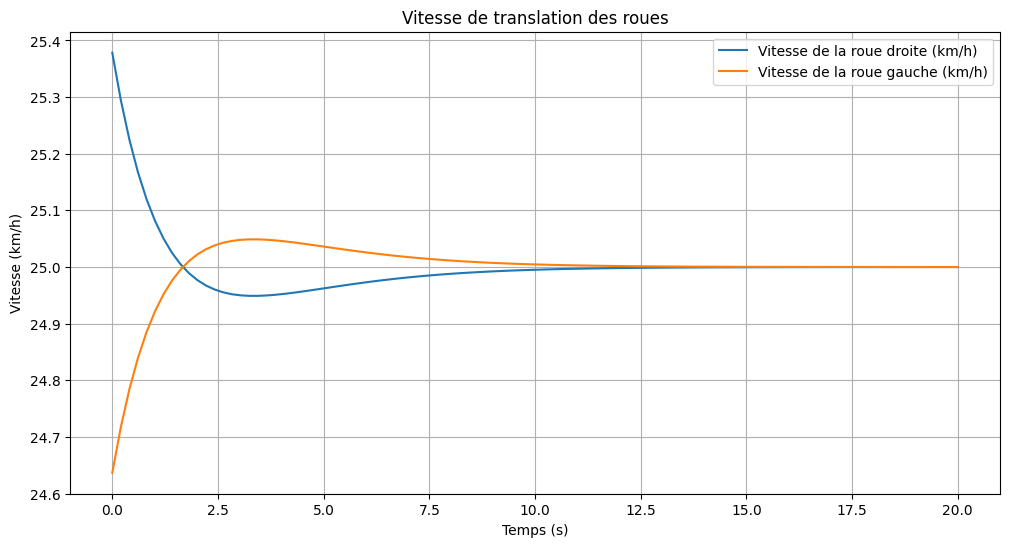

In [254]:
import matplotlib.pyplot as plt
import numpy as np


v = 25  
r = 0.125  
v_mps = v / 3.6  
t = np.linspace(0, 20, 100)  


omega_l = dOmega_l + v_mps / r
omega_r = dOmega_r + v_mps / r


vitesse_roue_droite = omega_r * r * 3.6  
vitesse_roue_gauche = omega_l * r * 3.6 

fig = plt.figure(figsize=(12, 6))
plt.plot(t, vitesse_roue_droite, label="Vitesse de la roue droite (km/h)")
plt.plot(t, vitesse_roue_gauche, label="Vitesse de la roue gauche (km/h)")
plt.title("Vitesse de translation des roues")
plt.xlabel("Temps (s)")
plt.ylabel("Vitesse (km/h)")
plt.grid(True)
plt.legend()
plt.show()

##### 🧩 Are these control values consistent with what the robot should do to cancel the error?

S'il n'y avait pas d'erreur, les deux roues doivent tourner à la même vitesse, notamment v = 50 km/h. 
Réellement, le robot est légèrement haut, donc il doit tourner vers la droite. Pour ce faire, la roue gauche doit tourner plus vite que la droite. 

###  Controller Tuning



##### 🧩 Tune the poles (and recompute the gain matrix) so that the actual location $(x, y)$ is within 10 cm of the desired location within 20 sec but the angle $\Delta \theta$ never exceeds $\pm 5 \, \mathrm{deg}$. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

##### 🧩 Simulate the initial, nonlinear scooter model when the control law computed in the section "Controller Tuning" is applied. Check that the constraint given for the control law design still hold.

In [ ]:
pass

##### 🧩 Display the first 5 seconds of this trajectory using a snapshot of the scooter in the plane every 0.25 second.

In [ ]:
pass